In [1]:
# !pip install --upgrade numpy
# !pip install --upgrade pandas
# !pip install --upgrade matplotlib
# !pip install --upgrade seaborn
# !pip install --upgrade scikit-learn
# !pip install --upgrade tensorflow

In [2]:
import numpy as np
import copy
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from keras import Sequential, Model, layers, callbacks, optimizers
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Dropout, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
# from sklearn.model_selection import GridSearchCV
#from keras.wrappers.scikit_learn import KerasClassifier
# from scikeras.wrappers import KerasRegressor, KerasClassifier
# import keras

from sklearn.metrics import mean_squared_error, mean_absolute_error

2024-05-25 21:41:15.857692: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-25 21:41:15.857745: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-25 21:41:15.859415: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-25 21:41:15.868550: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
milk_df = pd.read_csv("milk.csv", parse_dates=["Date"])
milk_df.dropna(how='any', axis=0, inplace=True, ignore_index=True)
df = milk_df.drop('Date', axis=1)
df = df.drop('dim2', axis=1)
df = df.drop('Cond', axis=1)
df = df.drop('Peak', axis=1)
print(df)

       AnEar  lactation  dim  milk_production  MilkShif    Dur
0        123          4    1             11.5     11.50  276.0
1        123          4    2             48.4     24.20  384.0
2        123          4    3             66.4     33.20  672.0
3        123          4    4             57.1     28.55  354.0
4        123          4    5             78.5     39.25  396.0
...      ...        ...  ...              ...       ...    ...
25841   9977          2  301             72.8     36.40  540.0
25842   9977          2  302             73.0     36.50  600.0
25843   9977          2  303             70.9     35.45  540.0
25844   9977          2  304             70.6     35.30  516.0
25845   9977          2  305             67.7     33.85  522.0

[25846 rows x 6 columns]


In [4]:
dv_treino = {}
dv_teste = {}
nomes_vacas = df['AnEar'].unique()
print(nomes_vacas)
for nome in nomes_vacas:
    vals = df[df['AnEar'] == nome].values
    vals = np.delete(vals, 0, axis=1)
    dv_treino[nome] = vals[:50]
    dv_teste[nome] = vals[50:]


[ 123 1009 1017 1209 1218 1242 1243 1275 1280 1305 1327 1329 1341 1362
 1368 1387 1393 7761 8064 8334 8385 8393 8434 8435 8438 8509 8581 8667
 8723 8732 8741 8932 8947 8996 9005 9066 9069 9078 9081 9090 9101 9149
 9188 9207 9284 9346 9363 9388 9389 9431 9463 9464 9478 9487 9488 9525
 9529 9549 9558 9562 9583 9885 9891 9892 9894 9908 9909 9910 9917 9918
 9920 9922 9926 9928 9929 9933 9939 9943 9944 9946 9951 9961 9967 9968
 9977]


In [5]:
dv_treino_aug = {}
for nome in nomes_vacas:
    new_vals = []
    vals = dv_treino[nome]
    for i in range(0, len(vals)-1):
        new_vals.append(vals[i])
        new_line = [(vi+vf)/2 for vi, vf in zip(vals[i], vals[i+1])]
        new_vals.append(new_line)
    new_vals.append(vals[len(vals)-1])

    dv_treino_aug[nome] = np.array(new_vals)

dv_treino_aug[nomes_vacas[0]]

array([[  4.   ,   1.   ,  11.5  ,  11.5  , 276.   ],
       [  4.   ,   1.5  ,  29.95 ,  17.85 , 330.   ],
       [  4.   ,   2.   ,  48.4  ,  24.2  , 384.   ],
       [  4.   ,   2.5  ,  57.4  ,  28.7  , 528.   ],
       [  4.   ,   3.   ,  66.4  ,  33.2  , 672.   ],
       [  4.   ,   3.5  ,  61.75 ,  30.875, 513.   ],
       [  4.   ,   4.   ,  57.1  ,  28.55 , 354.   ],
       [  4.   ,   4.5  ,  67.8  ,  33.9  , 375.   ],
       [  4.   ,   5.   ,  78.5  ,  39.25 , 396.   ],
       [  4.   ,   5.5  ,  83.   ,  41.5  , 408.   ],
       [  4.   ,   6.   ,  87.5  ,  43.75 , 420.   ],
       [  4.   ,   6.5  ,  87.25 ,  43.625, 429.   ],
       [  4.   ,   7.   ,  87.   ,  43.5  , 438.   ],
       [  4.   ,   7.5  ,  90.   ,  45.   , 456.   ],
       [  4.   ,   8.   ,  93.   ,  46.5  , 474.   ],
       [  4.   ,   8.5  ,  94.95 ,  47.475, 468.   ],
       [  4.   ,   9.   ,  96.9  ,  48.45 , 462.   ],
       [  4.   ,   9.5  ,  95.1  ,  47.55 , 465.   ],
       [  4.   ,  10.   ,  9

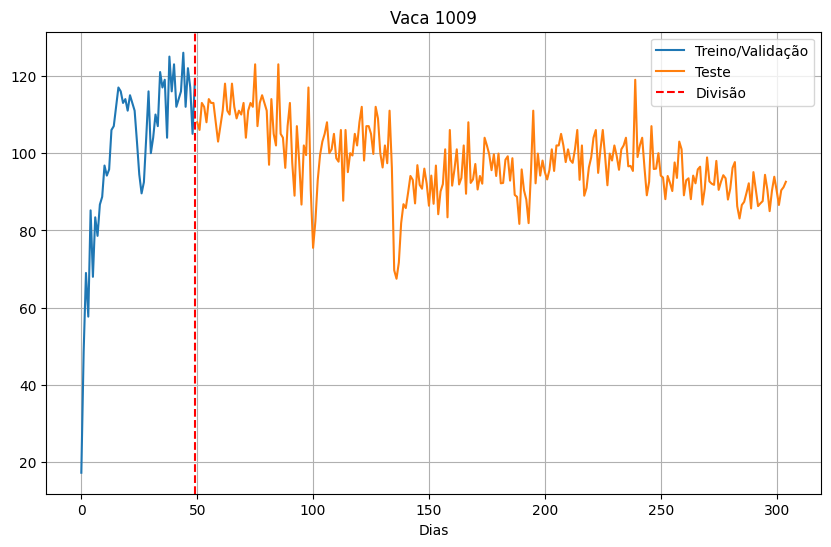

In [6]:
plt.figure(figsize=(10, 6))
vaca = 1009
plt.title(f"Vaca {vaca}")
sns.lineplot(x=np.arange(len(dv_treino[vaca][:, 2])), y=dv_treino[vaca][:, 2], label='Treino/Validação')
sns.lineplot(x=np.arange(50, len(dv_teste[vaca][:, 2])+50), y=dv_teste[vaca][:, 2], label='Teste')
plt.axvline(x=49, color='red', linestyle='--', label="Divisão")
# plt.ylabel("Produção de Leite (Lbs)")
plt.xlabel("Dias")
plt.legend()
plt.grid()
plt.show()

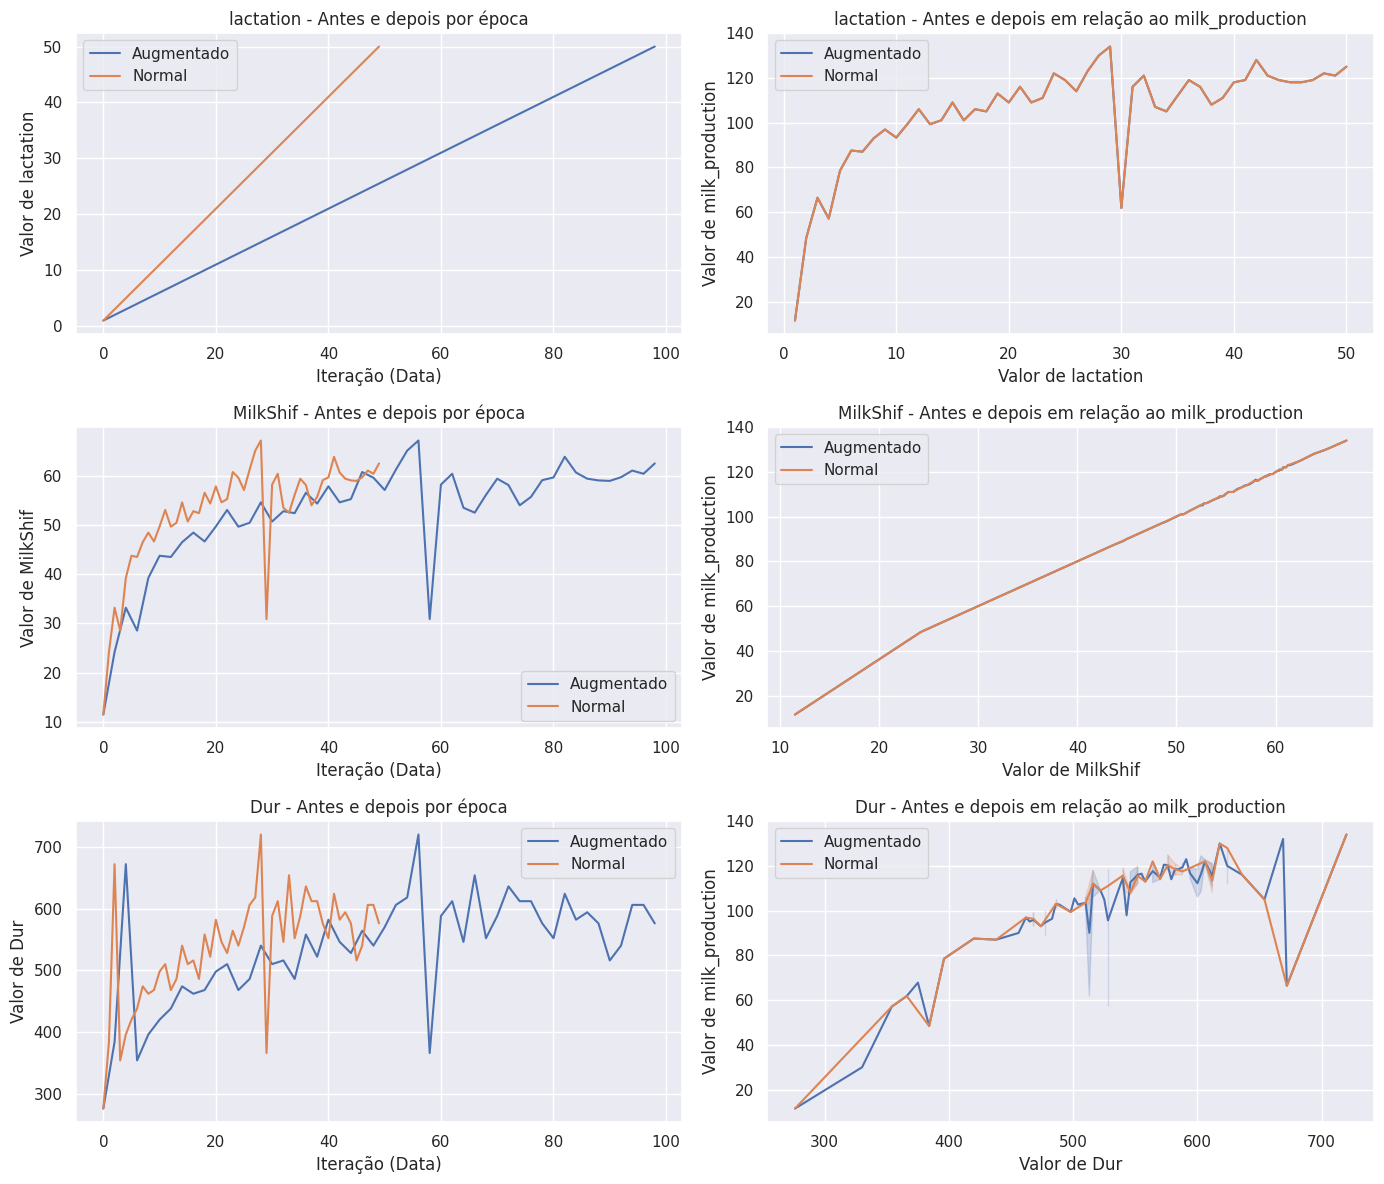

In [7]:
nome = nomes_vacas[0]
sns.set(style="darkgrid")
fig, axes = plt.subplots(3, 2, figsize=(14,12))
for i, (n, m) in enumerate(zip([1, 3, 4], ['lactation', 'MilkShif', 'Dur'])):
    sns.lineplot(x=np.arange(len(dv_treino_aug[nome][:, n])), y=dv_treino_aug[nome][:, n], ax=axes[i, 0], label='Augmentado')
    sns.lineplot(x=np.arange(len(dv_treino[nome][:, n])), y=dv_treino[nome][:, n], ax=axes[i, 0], label='Normal')
    
    axes[i, 0].set_xlabel("Iteração (Data)")
    axes[i, 0].set_ylabel(f"Valor de {m}")
    
    
    sns.lineplot(x=dv_treino_aug[nome][:, n], y=dv_treino_aug[nome][:, 2], ax=axes[i, 1], label='Augmentado')
    sns.lineplot(x=dv_treino[nome][:, n], y=dv_treino[nome][:, 2], ax=axes[i, 1], label='Normal')
    
    axes[i, 1].set_xlabel(f"Valor de {m}")
    axes[i, 1].set_ylabel("Valor de milk_production")

    axes[i, 0].set_title(f"{m} - Antes e depois por época")
    axes[i, 1].set_title(f"{m} - Antes e depois em relação ao milk_production")

plt.tight_layout()
plt.legend()
plt.show()

### Definir modelo

In [8]:
def get_model(input_size, hidden_layer_sizes, dropout, learning_rate, loss):
  model=Sequential()
  model.add(layers.InputLayer((input_size,)))
  model.add(layers.Flatten())
  model.add(layers.Dense(hidden_layer_sizes, activation="relu", kernel_initializer="he_uniform"))
  model.add(layers.Dropout(dropout))
  model.add(layers.BatchNormalization())
  model.add(layers.Dense(hidden_layer_sizes, activation="relu", kernel_initializer="he_uniform"))
  model.add(layers.Dropout(dropout))
  model.add(layers.BatchNormalization())
  model.add(layers.Dense(hidden_layer_sizes, activation="relu", kernel_initializer="he_uniform"))
  model.add(layers.Dropout(dropout))
  model.add(layers.BatchNormalization())
  model.add(layers.Dense(hidden_layer_sizes, activation="relu", kernel_initializer="he_uniform"))
  model.add(layers.Dropout(dropout))
  model.add(layers.Dense(1,activation="linear"))

  #final_model = Model([model.input], out)
  model.compile(loss=loss, optimizer=optimizers.Adam(learning_rate=learning_rate), metrics=['mae'])

  return model

In [9]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-05-25 21:41:20.492113: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-25 21:41:20.501488: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-25 21:41:20.503530: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

### Valores Normais

In [10]:
all_values = np.concatenate(list(dv_treino.values()), axis=0)
print(all_values.shape)
all_values

(4250, 5)


array([[  4.  ,   1.  ,  11.5 ,  11.5 , 276.  ],
       [  4.  ,   2.  ,  48.4 ,  24.2 , 384.  ],
       [  4.  ,   3.  ,  66.4 ,  33.2 , 672.  ],
       ...,
       [  2.  ,  48.  , 108.  ,  54.2 , 684.  ],
       [  2.  ,  49.  , 115.  ,  57.25, 672.  ],
       [  2.  ,  50.  , 113.  ,  56.5 , 708.  ]])

In [11]:
x_train = np.delete(all_values, 2, axis=1)
print(x_train.shape)
x_train

(4250, 4)


array([[  4.  ,   1.  ,  11.5 , 276.  ],
       [  4.  ,   2.  ,  24.2 , 384.  ],
       [  4.  ,   3.  ,  33.2 , 672.  ],
       ...,
       [  2.  ,  48.  ,  54.2 , 684.  ],
       [  2.  ,  49.  ,  57.25, 672.  ],
       [  2.  ,  50.  ,  56.5 , 708.  ]])

In [12]:
y_train = all_values[:, 2].reshape(-1, 1)
print(y_train.shape)
y_train

(4250, 1)


array([[ 11.5],
       [ 48.4],
       [ 66.4],
       ...,
       [108. ],
       [115. ],
       [113. ]])

In [13]:
x_mmc = MinMaxScaler().fit(x_train)
x_train = x_mmc.transform(x_train)

y_mmc = MinMaxScaler().fit(y_train)
y_train = y_mmc.transform(y_train)

In [14]:
x_train

array([[0.42857143, 0.        , 0.07565185, 0.23316062],
       [0.42857143, 0.01052632, 0.16893133, 0.32642487],
       [0.42857143, 0.02105263, 0.23503489, 0.57512953],
       ...,
       [0.14285714, 0.49473684, 0.38927653, 0.58549223],
       [0.14285714, 0.50526316, 0.4116783 , 0.57512953],
       [0.14285714, 0.51578947, 0.40616967, 0.60621762]])

In [15]:
y_train

array([[0.0377566 ],
       [0.17302053],
       [0.23900293],
       ...,
       [0.3914956 ],
       [0.41715543],
       [0.40982405]])

In [16]:
modelo_normal = get_model(input_size=4, hidden_layer_sizes=256, dropout=0.3, learning_rate=0.001, loss='mean_absolute_error')
name = "modelo_normal"
hist_normal = modelo_normal.fit(
    x_train,
    y_train,
    epochs=100,
    batch_size=16,
    validation_split=0.3,
    callbacks=[
        ModelCheckpoint(filepath=f"weights/{name}.keras",save_best_only=True,verbose=0)
    ],
    verbose=0
)

2024-05-25 21:41:20.583446: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-25 21:41:20.585631: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-25 21:41:20.587767: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [17]:
all_aug_values = np.concatenate(list(dv_treino_aug.values()), axis=0)
x_train_aug = np.delete(all_aug_values, 2, axis=1)
y_train_aug = all_aug_values[:, 2].reshape(-1, 1)
print(all_aug_values.shape, x_train_aug.shape, y_train_aug.shape)

(8415, 5) (8415, 4) (8415, 1)


In [18]:
x_train_aug

array([[  4.   ,   1.   ,  11.5  , 276.   ],
       [  4.   ,   1.5  ,  17.85 , 330.   ],
       [  4.   ,   2.   ,  24.2  , 384.   ],
       ...,
       [  2.   ,  49.   ,  57.25 , 672.   ],
       [  2.   ,  49.5  ,  56.875, 690.   ],
       [  2.   ,  50.   ,  56.5  , 708.   ]])

In [19]:
y_train_aug

array([[ 11.5 ],
       [ 29.95],
       [ 48.4 ],
       ...,
       [115.  ],
       [114.  ],
       [113.  ]])

In [20]:
x_aug_mmc = MinMaxScaler().fit(x_train_aug)
x_train_aug = x_aug_mmc.transform(x_train_aug)

y_aug_mmc = MinMaxScaler().fit(y_train_aug)
y_train_aug = y_aug_mmc.transform(y_train_aug)

In [21]:
x_train_aug

array([[0.42857143, 0.        , 0.07565185, 0.23316062],
       [0.42857143, 0.00526316, 0.12229159, 0.27979275],
       [0.42857143, 0.01052632, 0.16893133, 0.32642487],
       ...,
       [0.14285714, 0.50526316, 0.4116783 , 0.57512953],
       [0.14285714, 0.51052632, 0.40892398, 0.59067358],
       [0.14285714, 0.51578947, 0.40616967, 0.60621762]])

In [22]:
print(y_train_aug)

[[0.0377566 ]
 [0.10538856]
 [0.17302053]
 ...
 [0.41715543]
 [0.41348974]
 [0.40982405]]


In [23]:
modelo_aug = get_model(input_size=4, hidden_layer_sizes=512, dropout=0.4, learning_rate=0.001, loss='mean_absolute_error')
name = "modelo_aug"
hist_aug = modelo_aug.fit(
    x_train_aug,
    y_train_aug,
    epochs=50,
    batch_size=16,
    validation_split=0.3,
    callbacks=[
        ModelCheckpoint(filepath=f"weights/{name}.keras",save_best_only=True,verbose=0)
    ],
    verbose=0
)

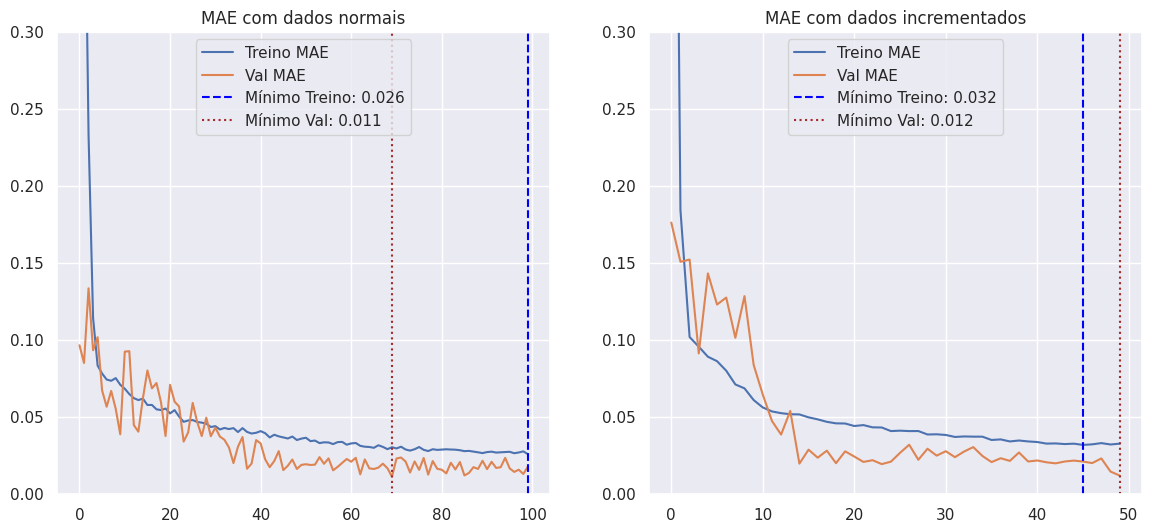

In [24]:
plt.show()
fig, axes = plt.subplots(1, 2, figsize=(14,6))
plt.title('Comparação sem vs com Augmentation')
for i, h in enumerate([hist_normal.history, hist_aug.history]):
    axes[i].plot(h['mae'], label='Treino MAE')
    axes[i].plot(h['val_mae'], label='Val MAE')
    
    axes[i].set_ylim(0, 0.3)

    minim = min(h['mae'])
    axes[i].axvline(x=h['mae'].index(minim), color='blue', linestyle='--', label=f"Mínimo Treino: {minim:.3f}")
    
    minim = min(h['val_mae'])
    axes[i].axvline(x=h['val_mae'].index(minim), color='brown', linestyle=':', label=f"Mínimo Val: {minim:.3f}")
    axes[i].grid(True)
    axes[i].legend()
    
axes[0].set_title("MAE com dados normais")
axes[1].set_title("MAE com dados incrementados")


plt.show()

### Dados de teste

In [25]:
dv_teste[nome]

array([[  4.  ,  51.  , 128.  ,  63.8 , 588.  ],
       [  4.  ,  52.  , 137.  ,  68.65, 654.  ],
       [  4.  ,  53.  , 129.  ,  64.6 , 582.  ],
       ...,
       [  4.  , 303.  ,  49.6 ,  24.8 , 378.  ],
       [  4.  , 304.  ,  46.6 ,  23.3 , 408.  ],
       [  4.  , 305.  ,  47.8 ,  23.9 , 450.  ]])

In [26]:
all_test_values = np.concatenate(list(dv_teste.values()), axis=0)
x_test = np.delete(all_test_values, 2, axis=1)
y_test = all_test_values[:, 2].reshape(-1, 1)
print(all_test_values.shape, x_test.shape, y_test.shape)

(21596, 5) (21596, 4) (21596, 1)


In [27]:
### Teste sem aug
x_teste = x_mmc.transform(x_test)
y_teste = y_mmc.transform(y_test)

pred_normal = modelo_normal.predict(x_teste)
print("Modelo com dados normais")
print("MSE:", mean_squared_error(y_teste, pred_normal))
print("MAE:", mean_absolute_error(y_teste, pred_normal))

675/675 [==============================] - 1s 2ms/step
Modelo com dados normais
MSE: 0.005910285940681111
MAE: 0.06134799857993381


In [28]:
### Tex_teste = x_aug_mmc.transform(x_test)
x_aug_teste = x_aug_mmc.transform(x_test)
y_aug_teste = y_aug_mmc.transform(y_test)

pred_aug = modelo_aug.predict(x_aug_teste)
print("Modelo com dados aumentados")
print("MSE:", mean_squared_error(y_aug_teste, pred_aug))
print("MAE:", mean_absolute_error(y_aug_teste, pred_aug))

675/675 [==============================] - 1s 2ms/step
Modelo com dados aumentados
MSE: 0.002812445085388329
MAE: 0.03873207170500374


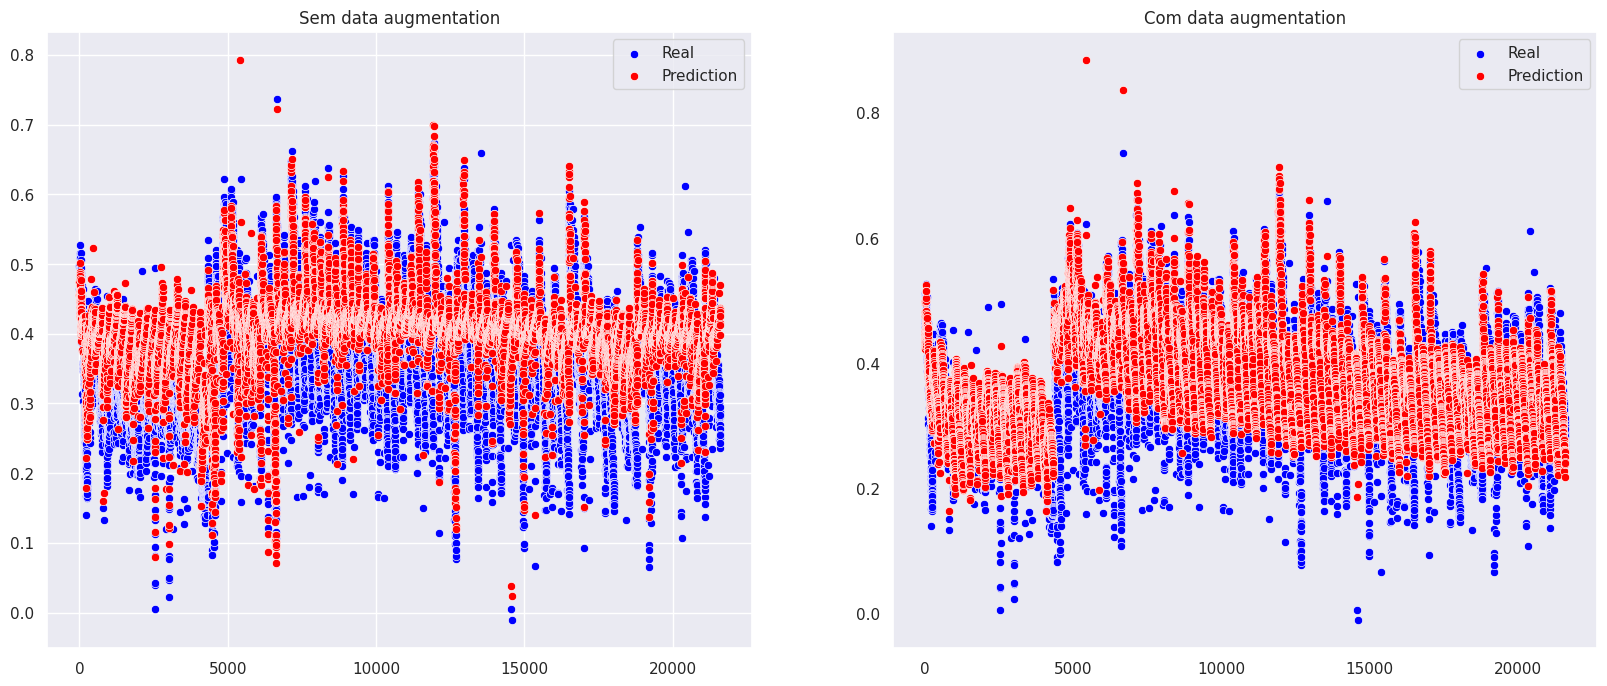

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(20,8))
sns.scatterplot(y_teste.reshape(-1), color='blue', ax=axes[0], label='Real')
sns.scatterplot(pred_normal.reshape(-1), color='red', ax=axes[0], label='Prediction')
axes[0].set_title("Sem data augmentation")

sns.scatterplot(y_aug_teste.reshape(-1), color='blue', ax=axes[1], label='Real')
sns.scatterplot(pred_aug.reshape(-1), color='red', ax=axes[1], label='Prediction')
axes[1].set_title("Com data augmentation")

plt.grid()
plt.legend()
plt.show()

In [30]:
# colunas = ["indice", "SEM_MAE", "SEM_MSE", "COM_MAE", "COM_MSE"]
resultados = {
    "indice": 2, 
    "SEM_MAE": mean_absolute_error(y_teste, pred_normal), 
    "SEM_MSE": mean_squared_error(y_teste, pred_normal), 
    "COM_MAE": mean_absolute_error(y_aug_teste, pred_aug), 
    "COM_MSE": mean_squared_error(y_aug_teste, pred_aug),
}
pd.DataFrame(resultados, index=[0]).to_csv(f'weights/res_4var_{resultados["indice"]}.csv', index=False)

### Por vaca

/var/tmp/ipykernel_1453681/2001743593.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(1, 3, figsize=(20, 8))


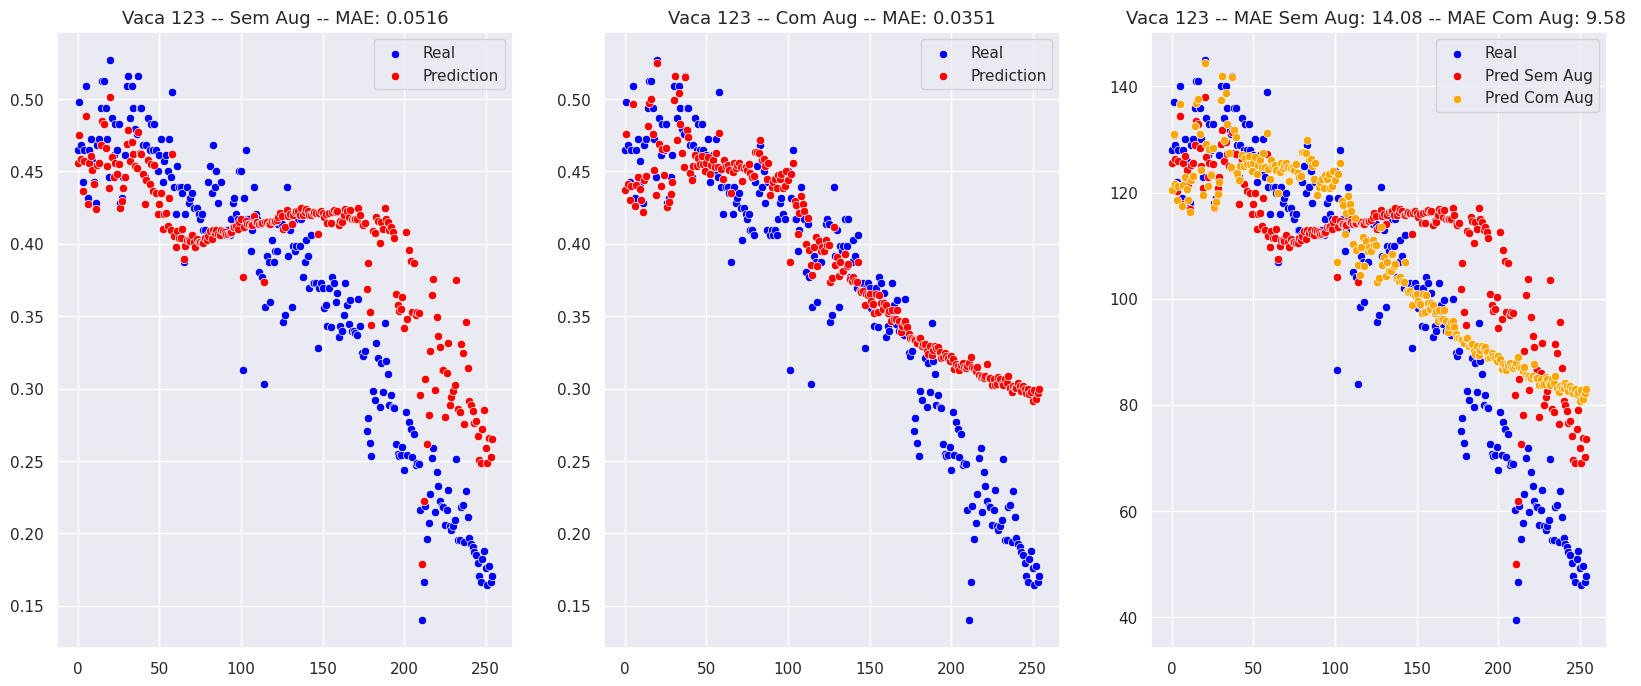

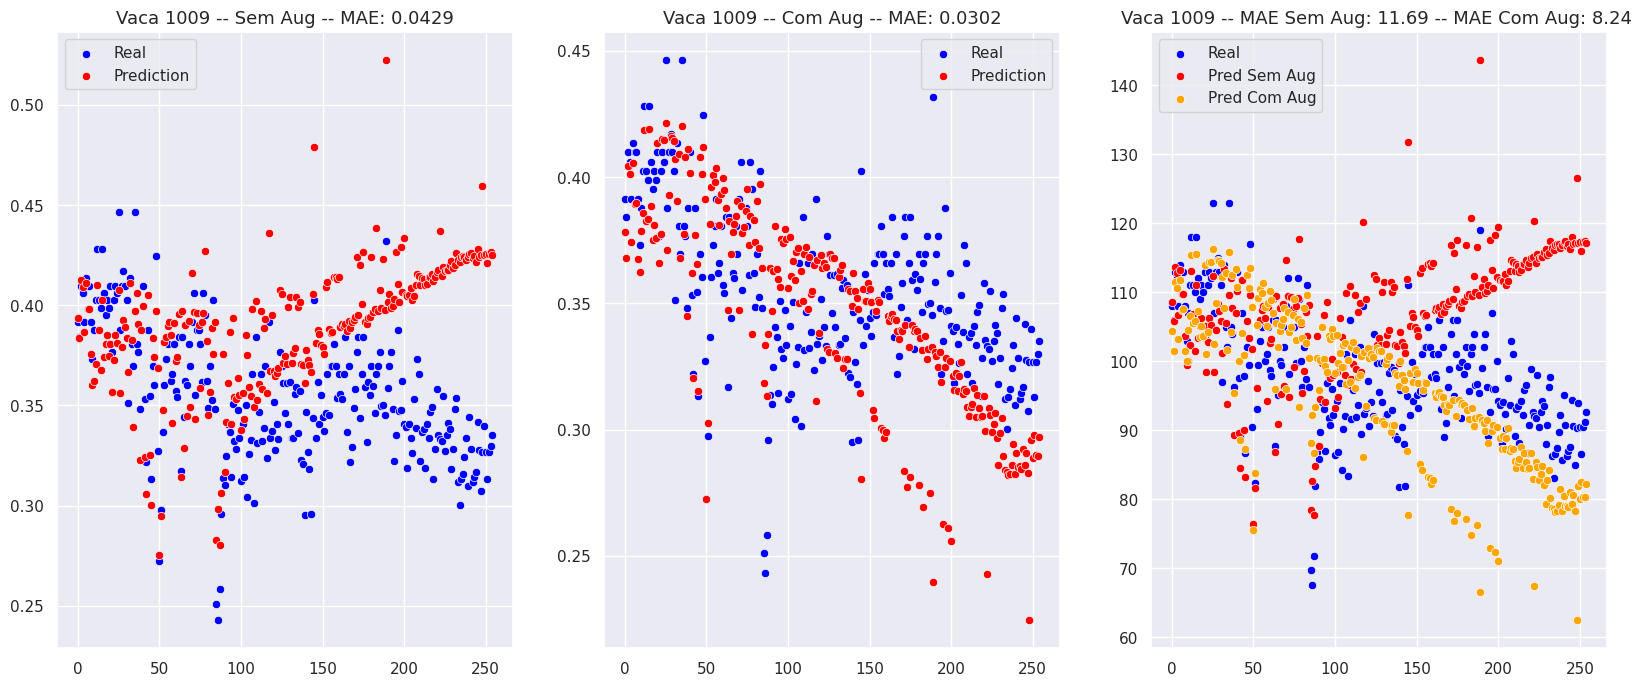

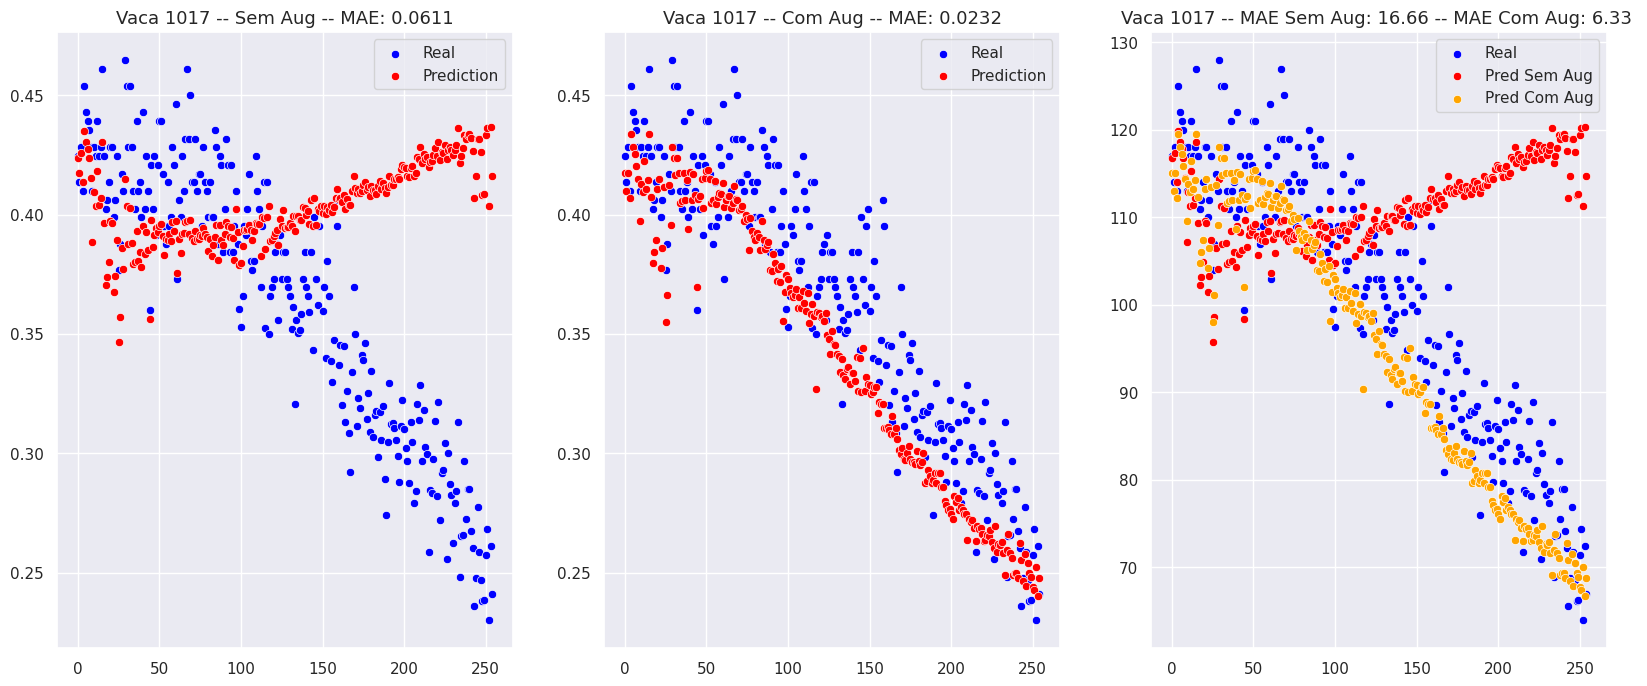

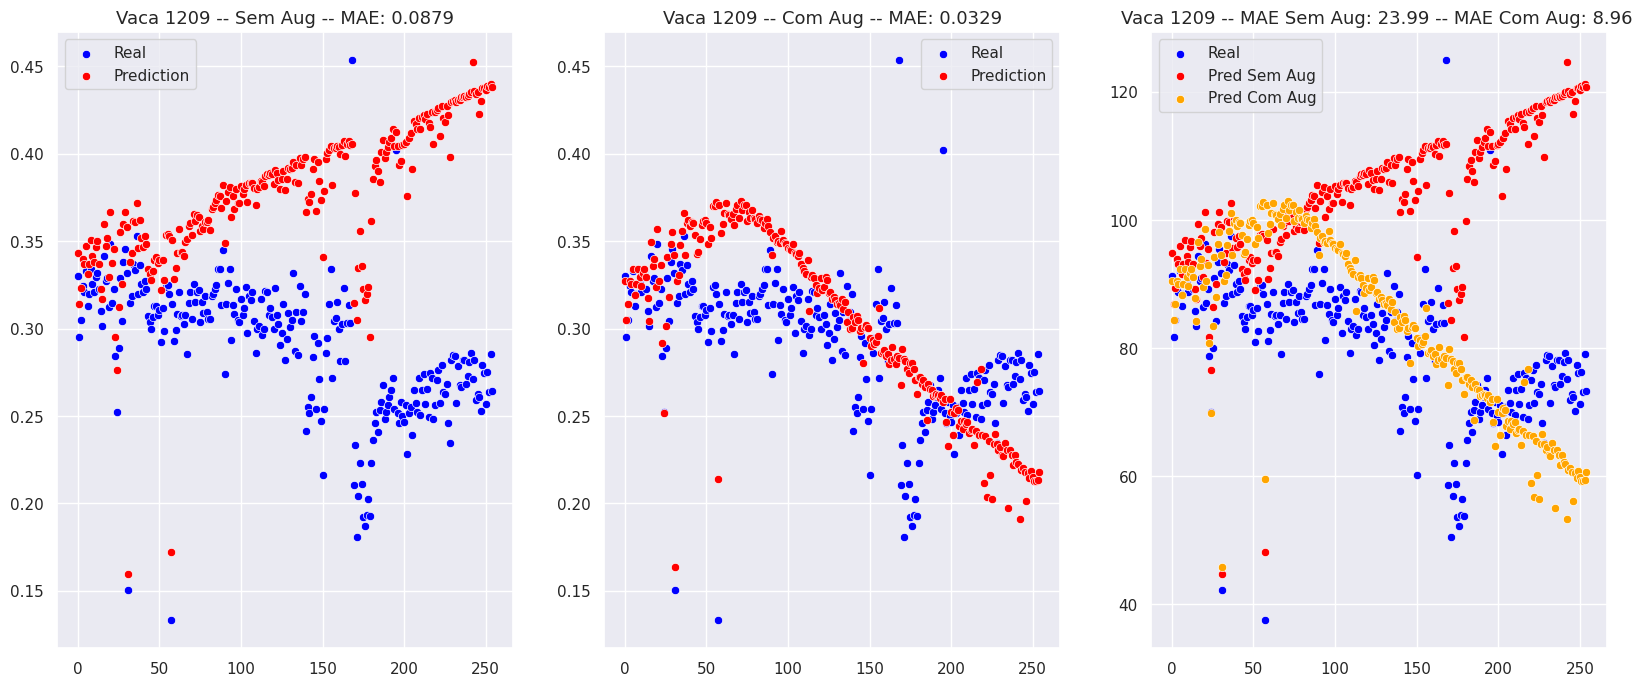

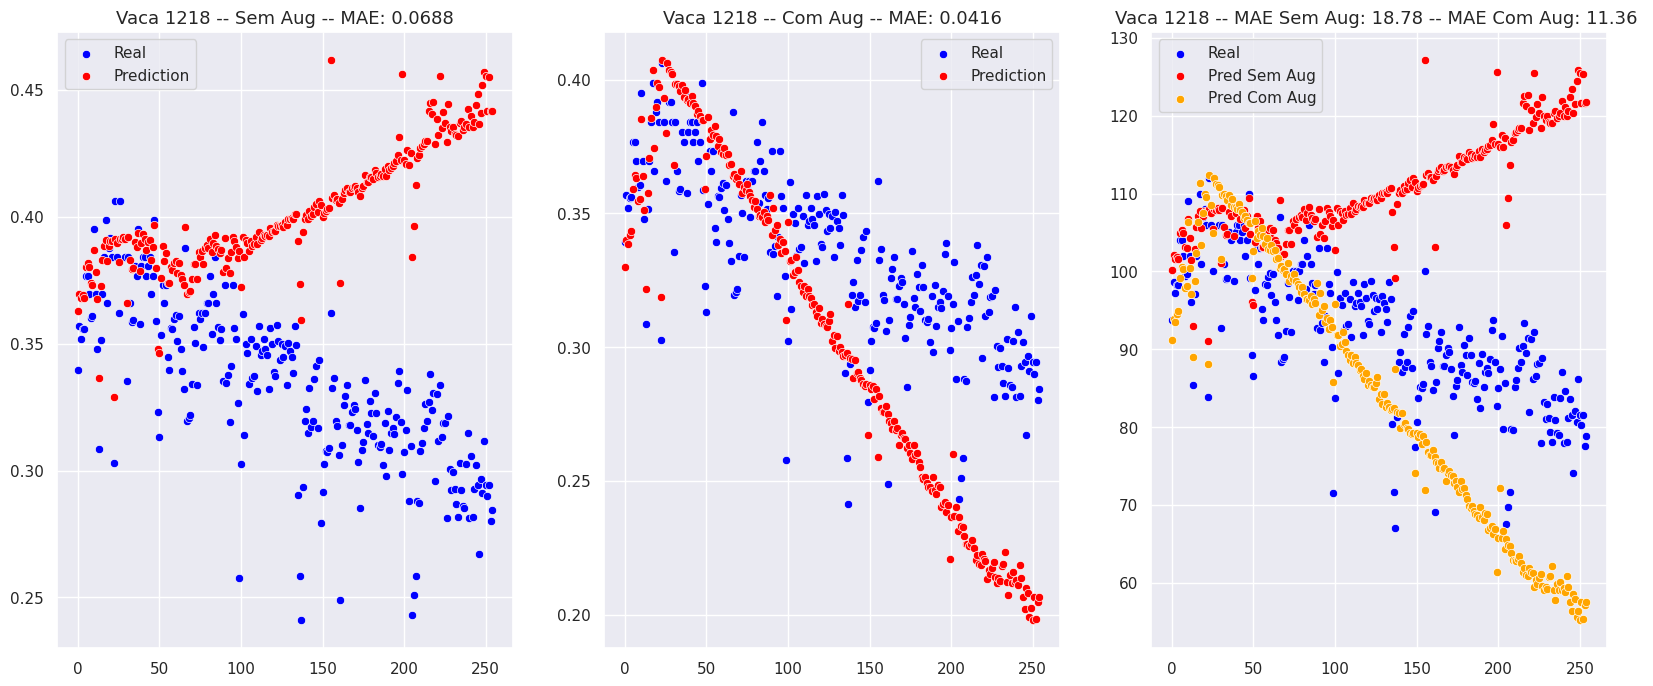

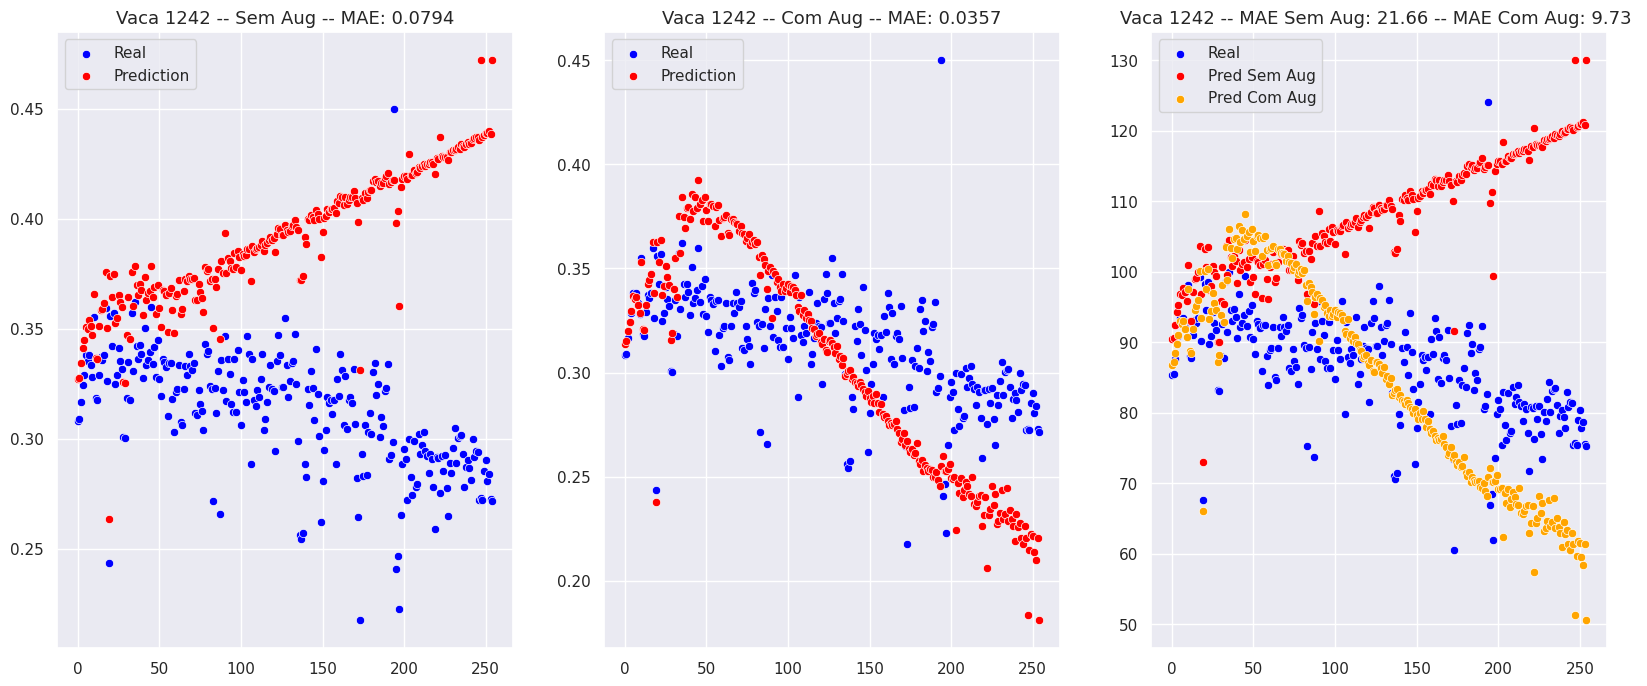

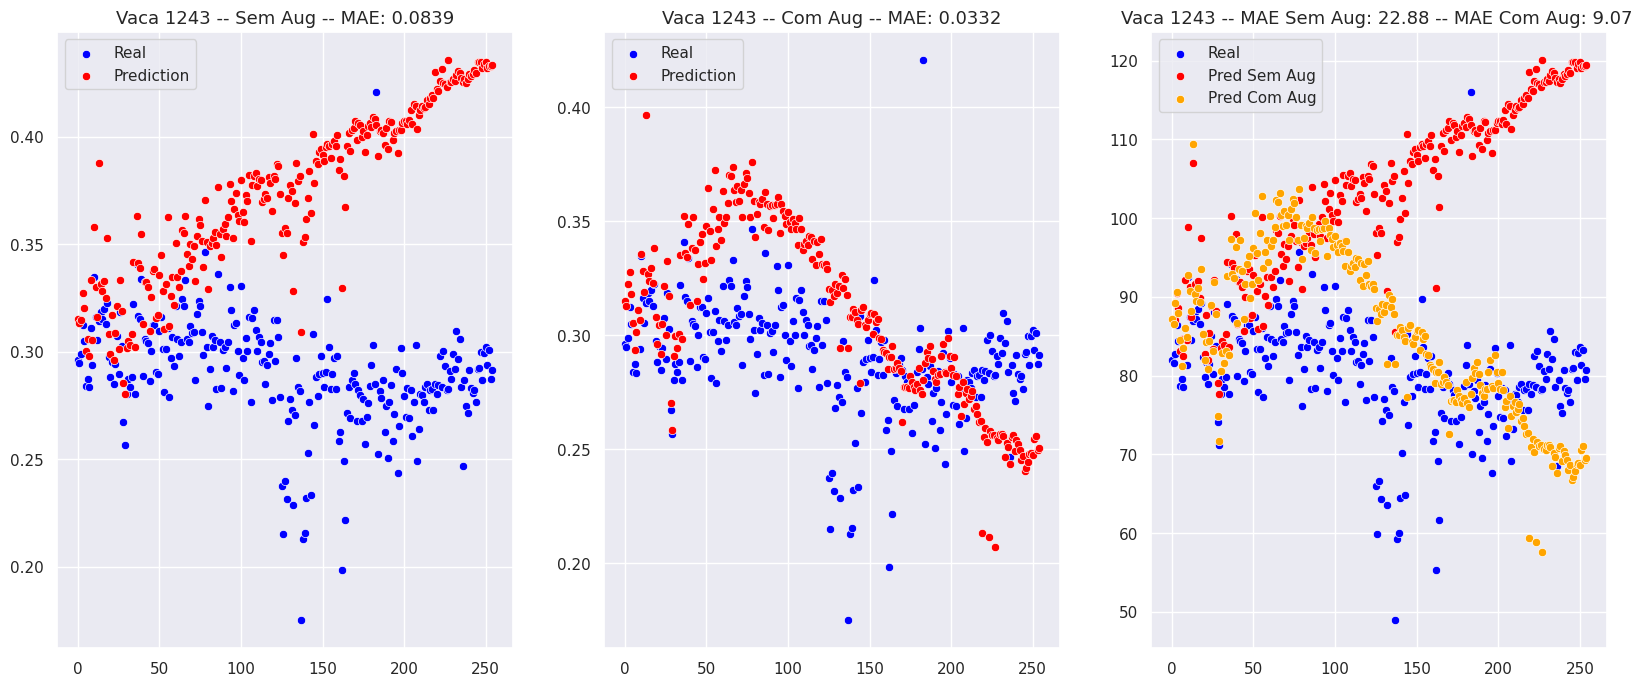

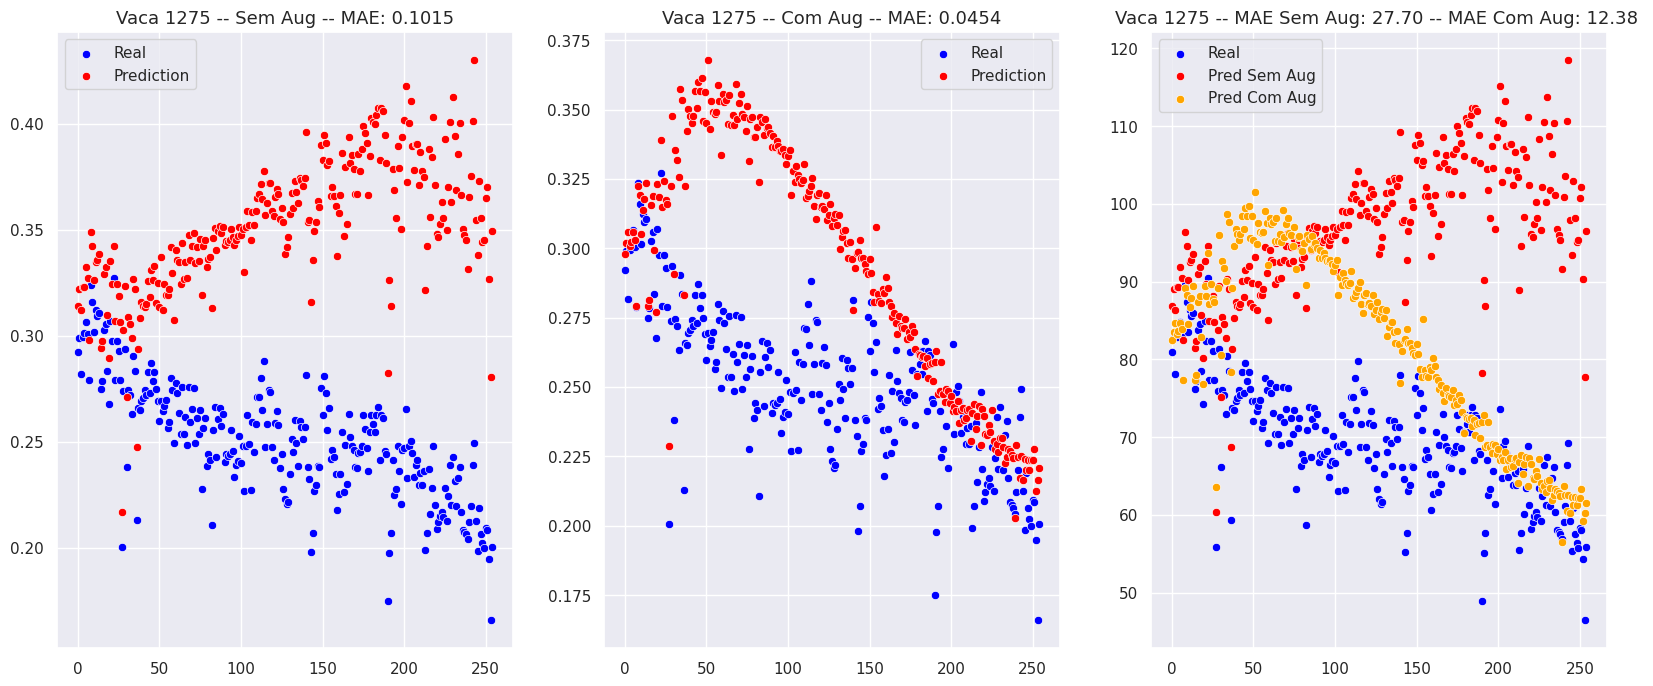

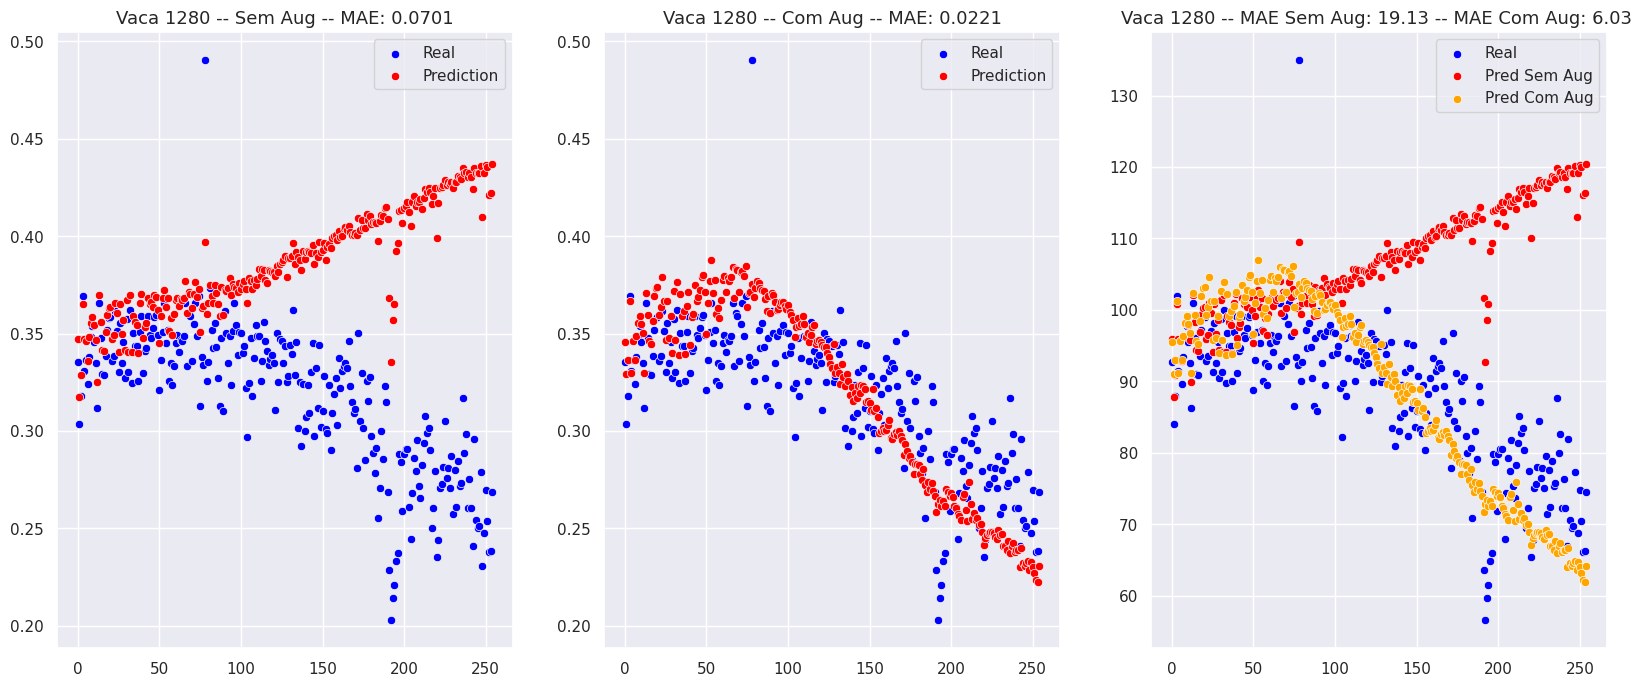

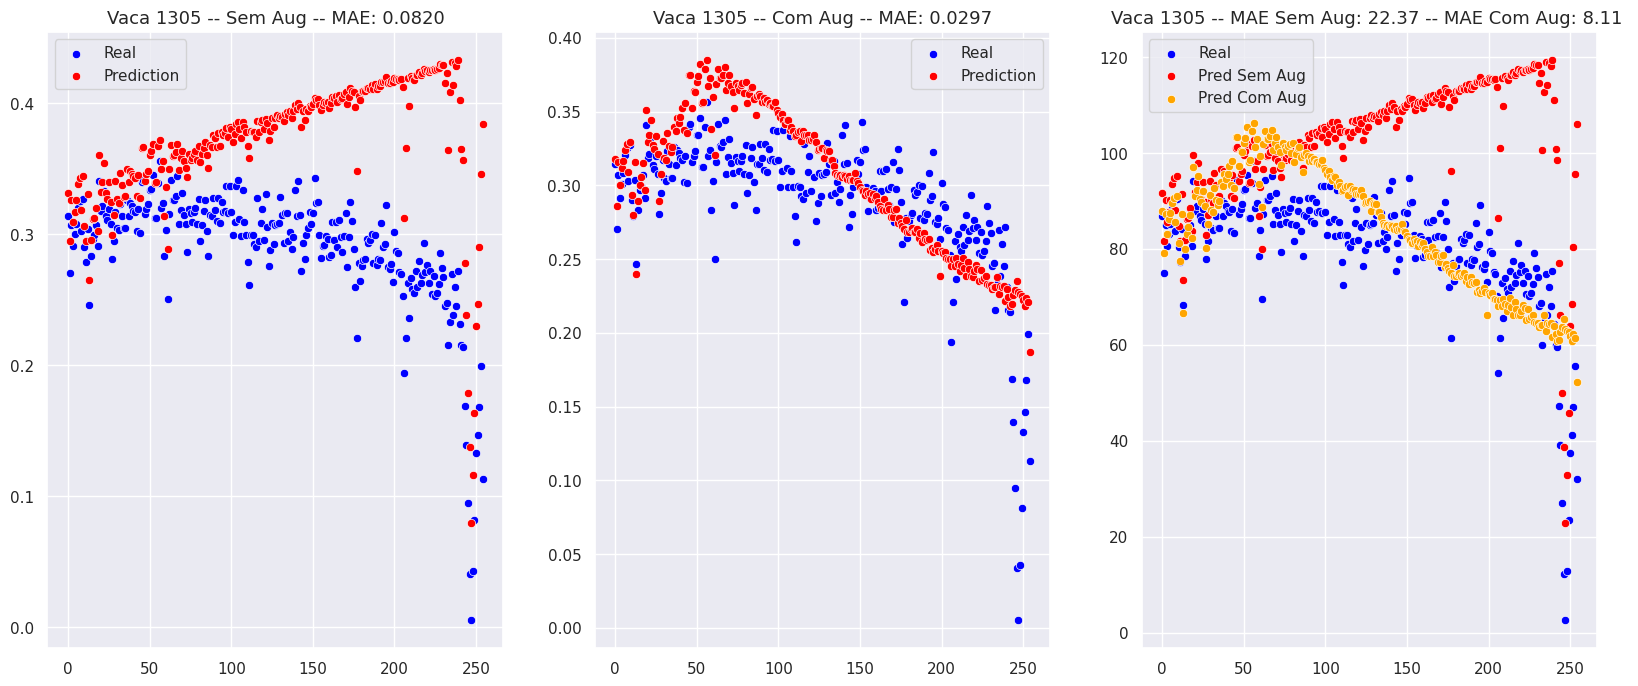

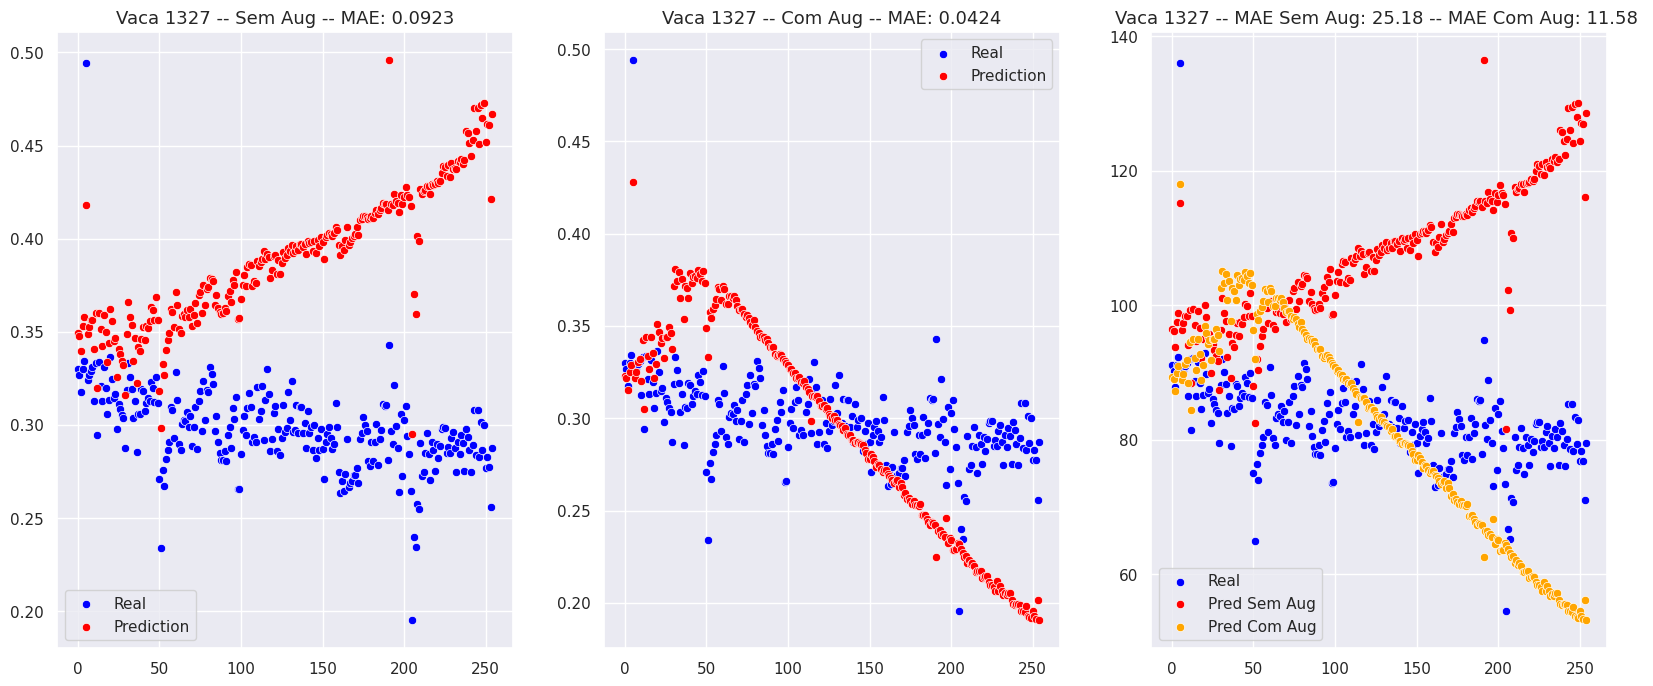

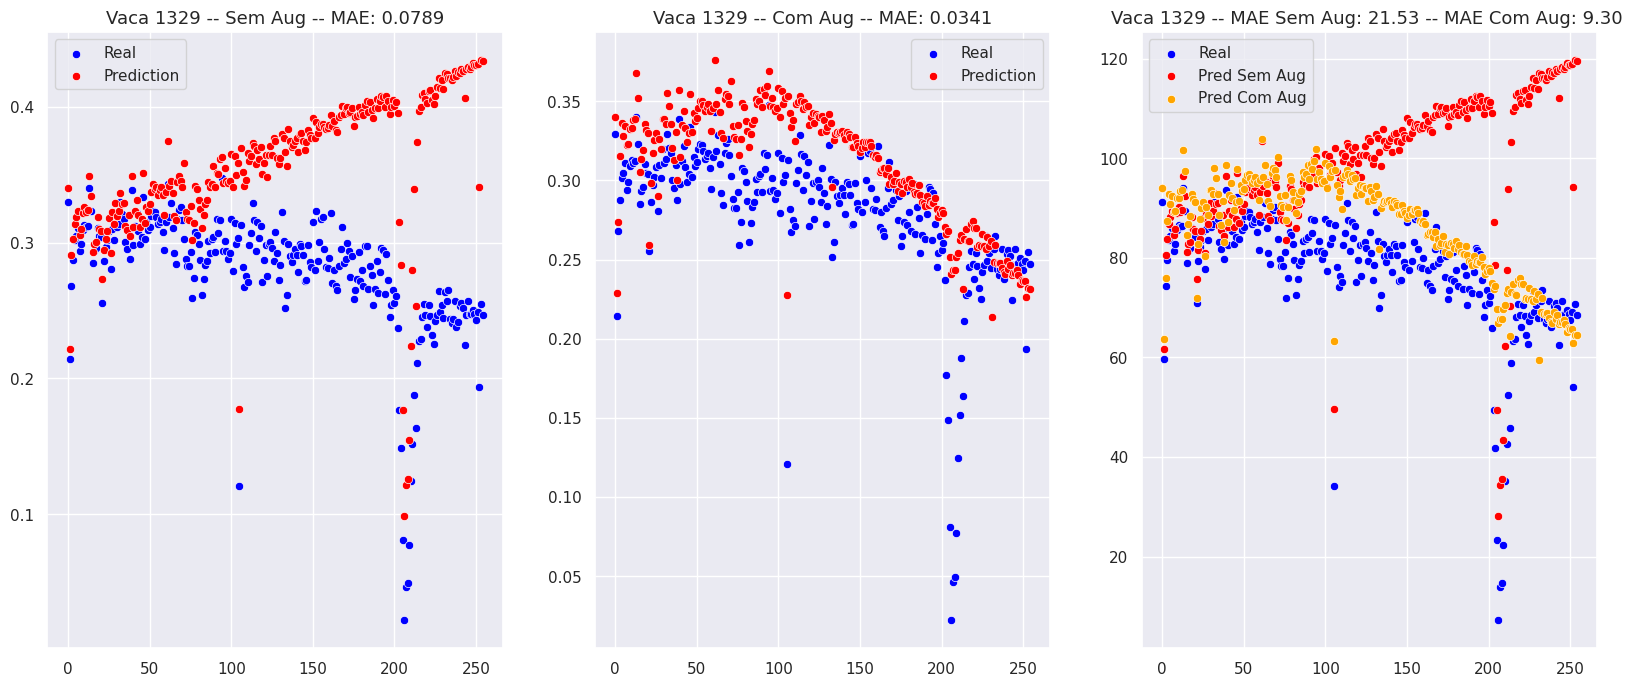

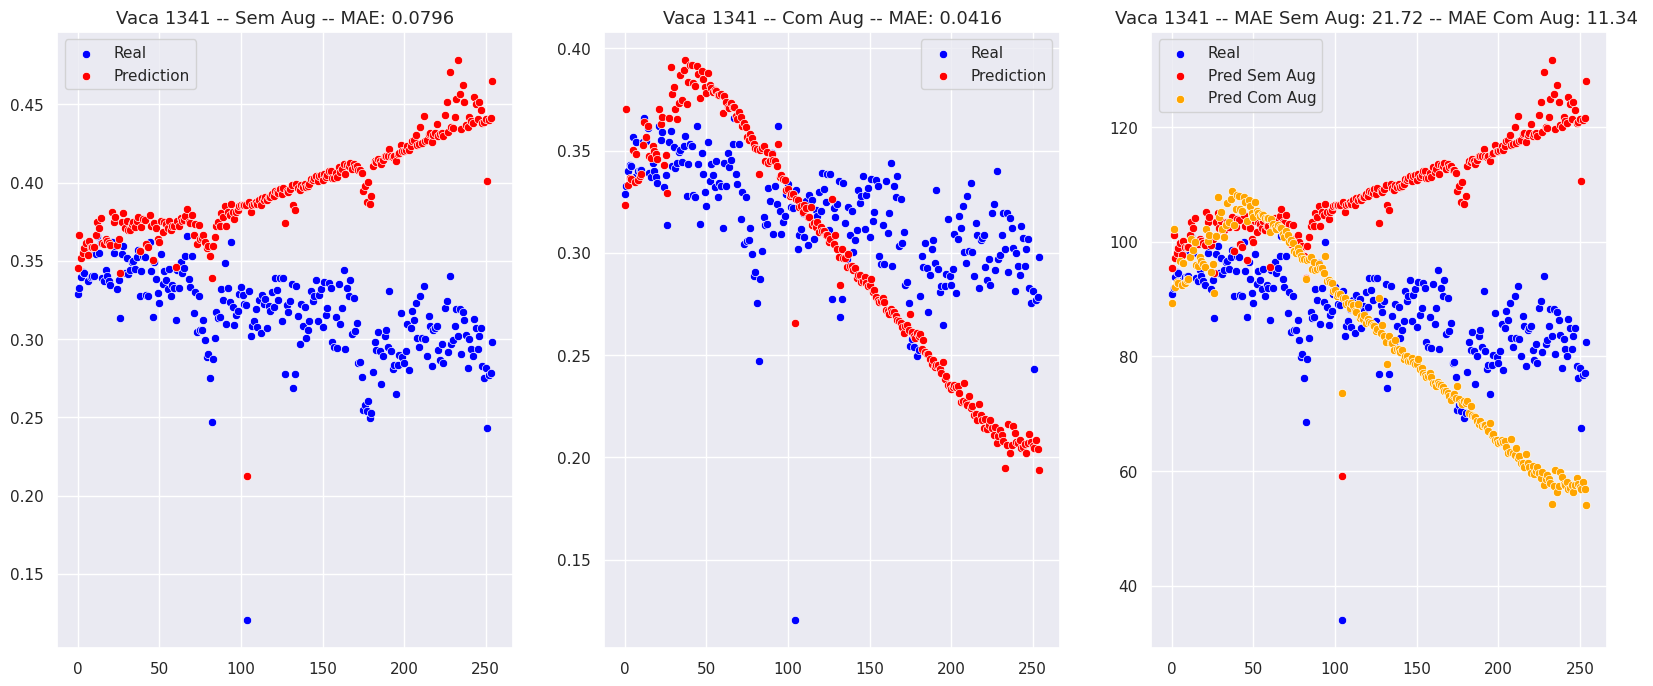

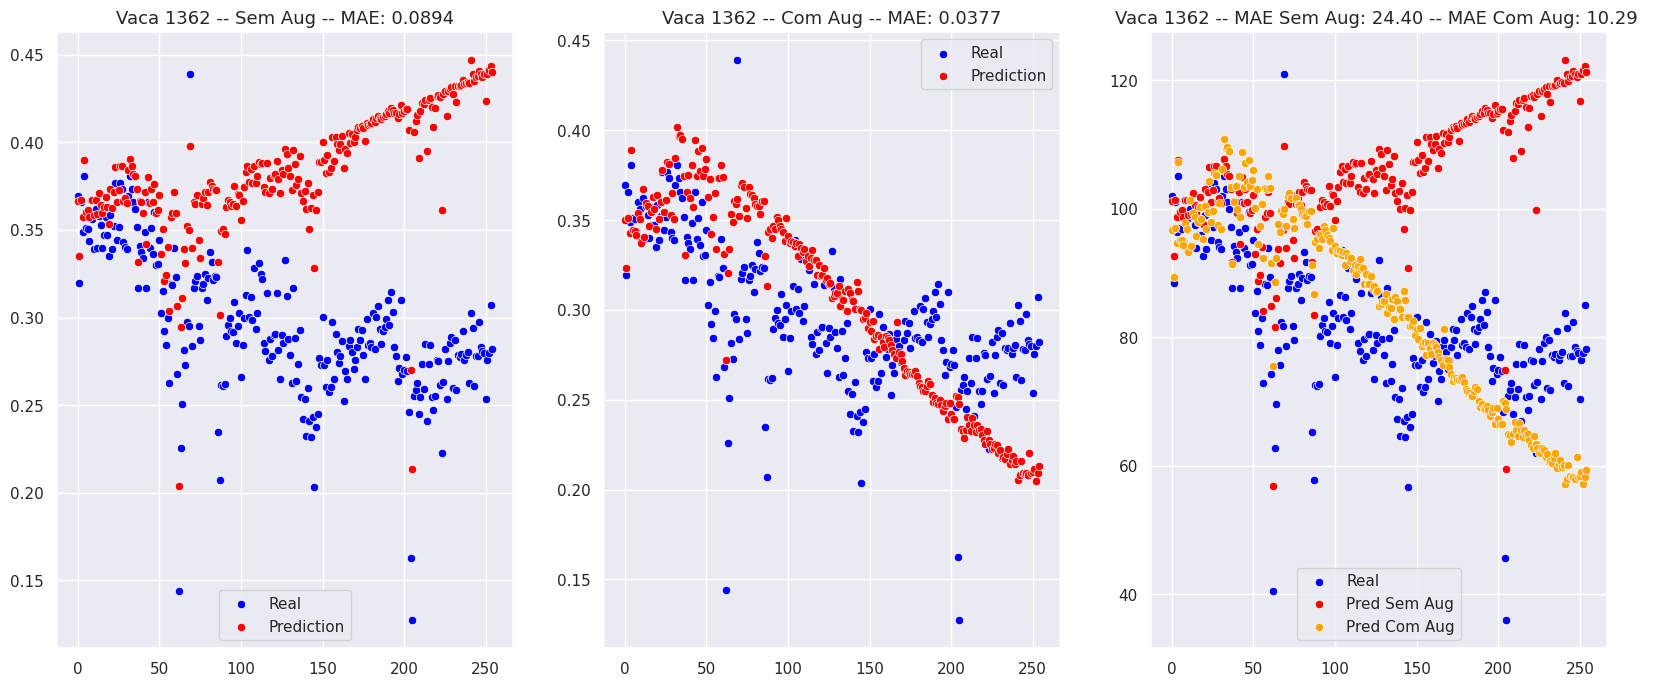

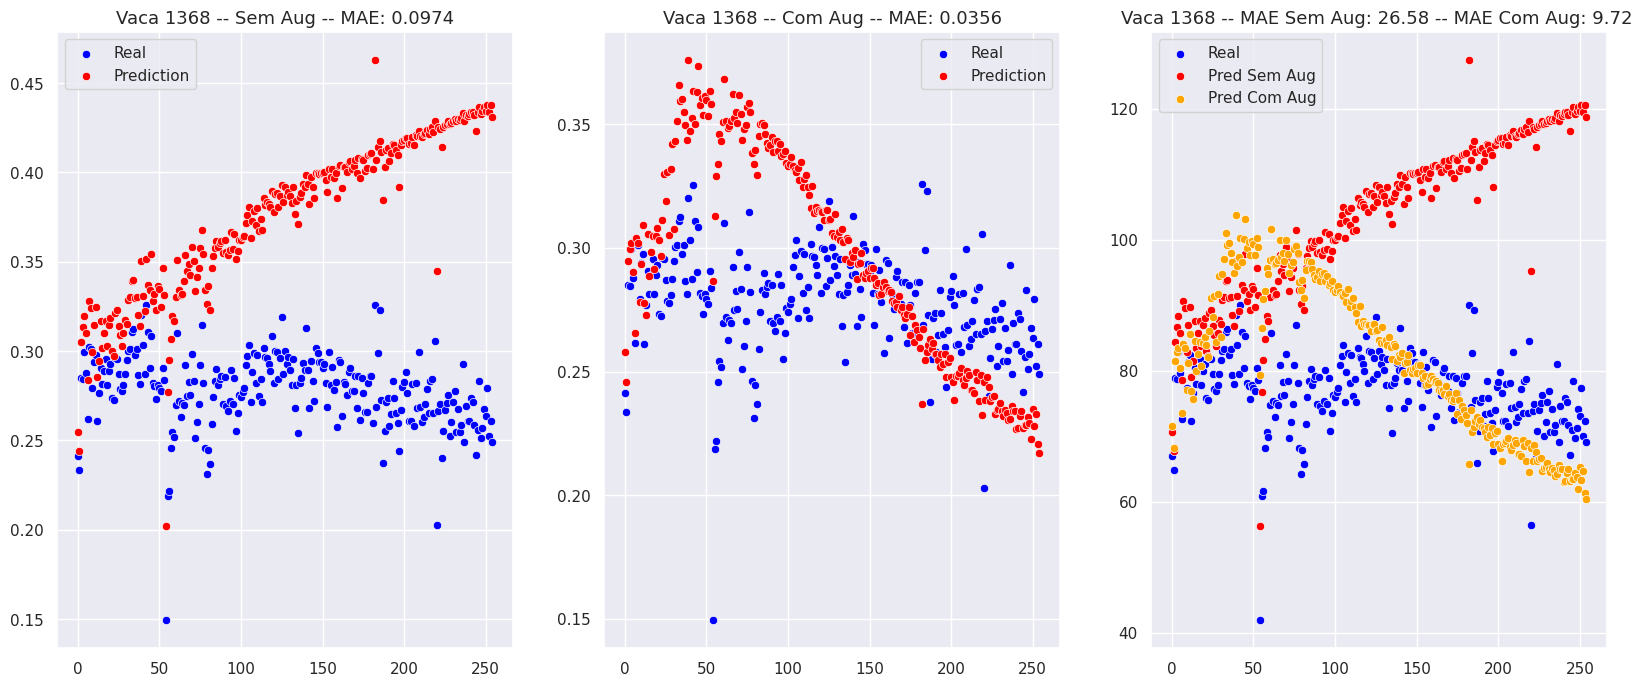

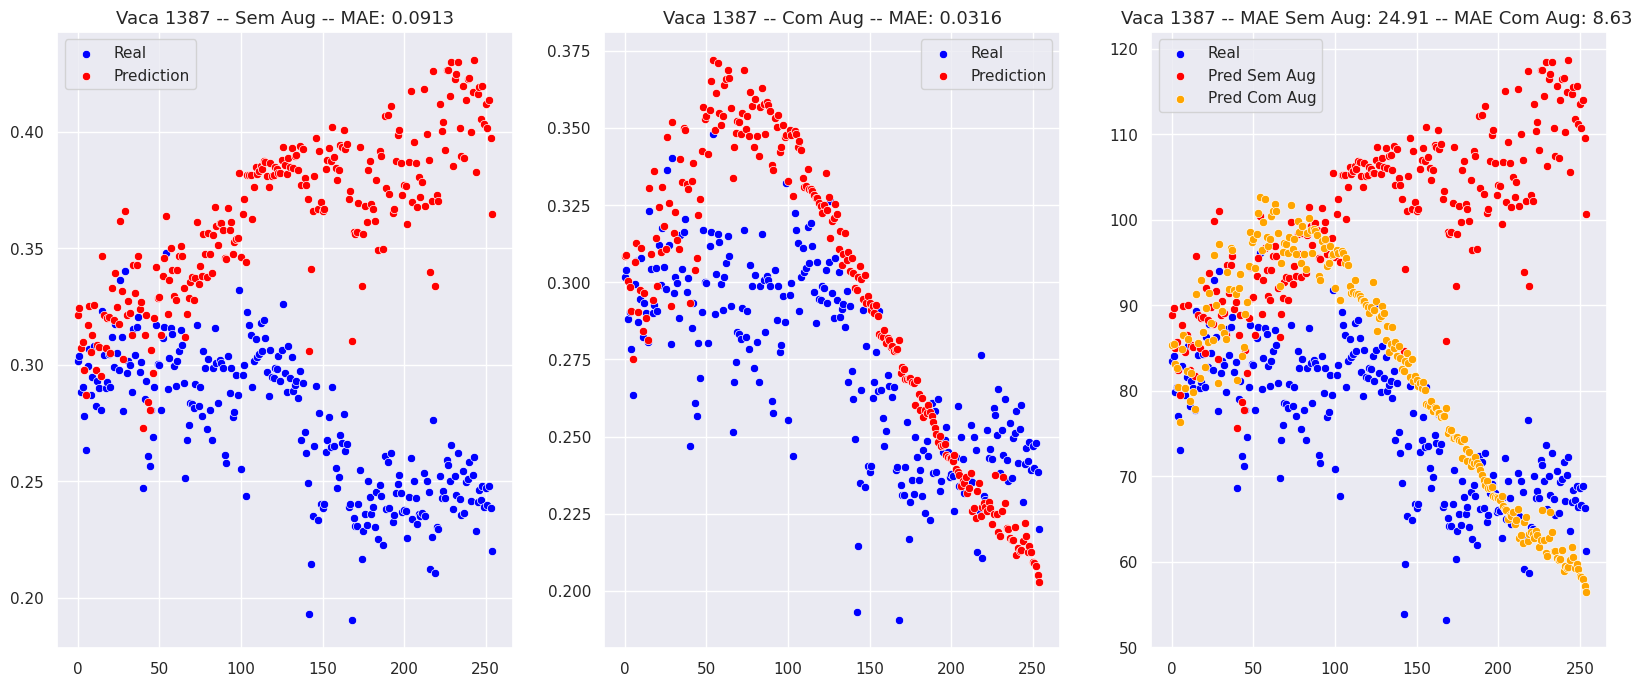

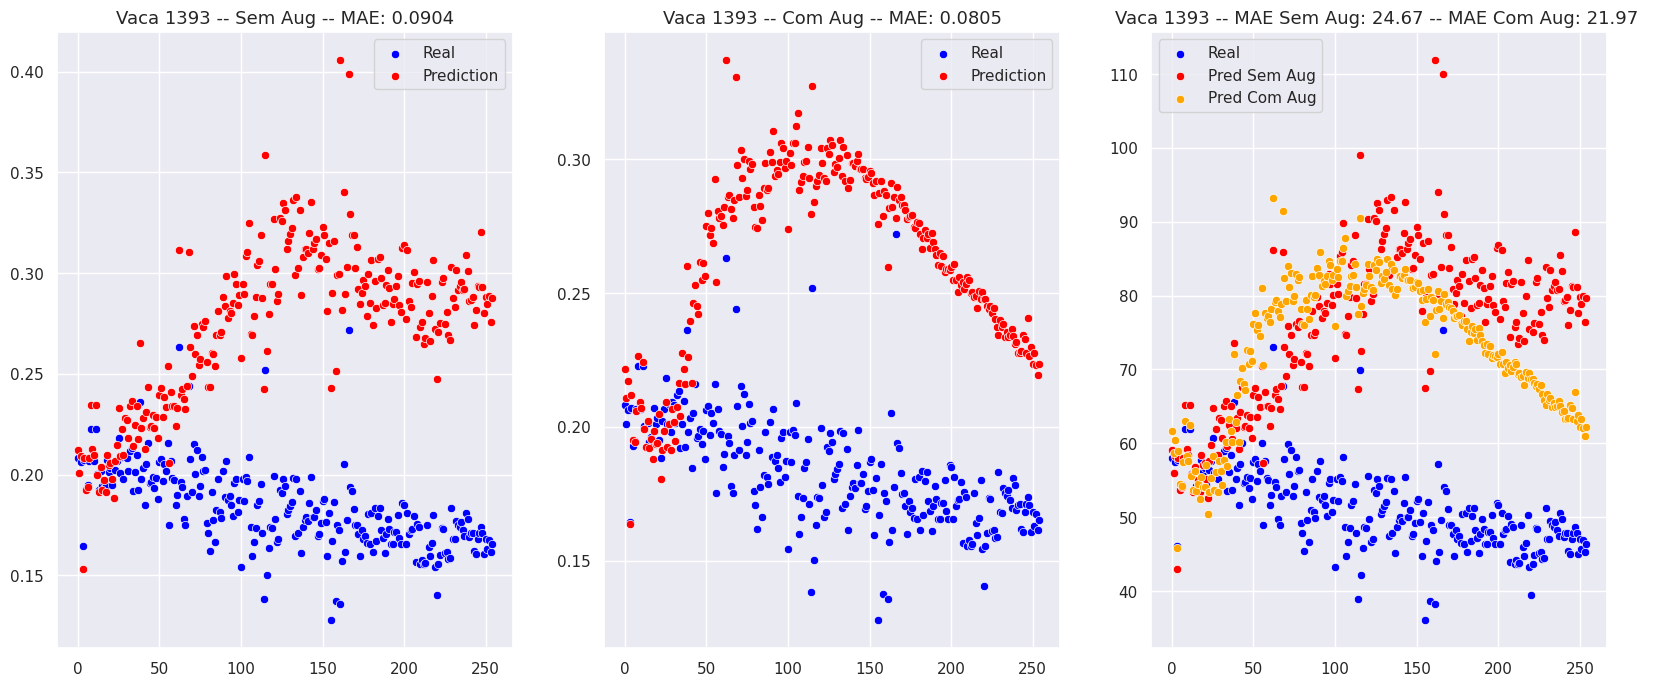

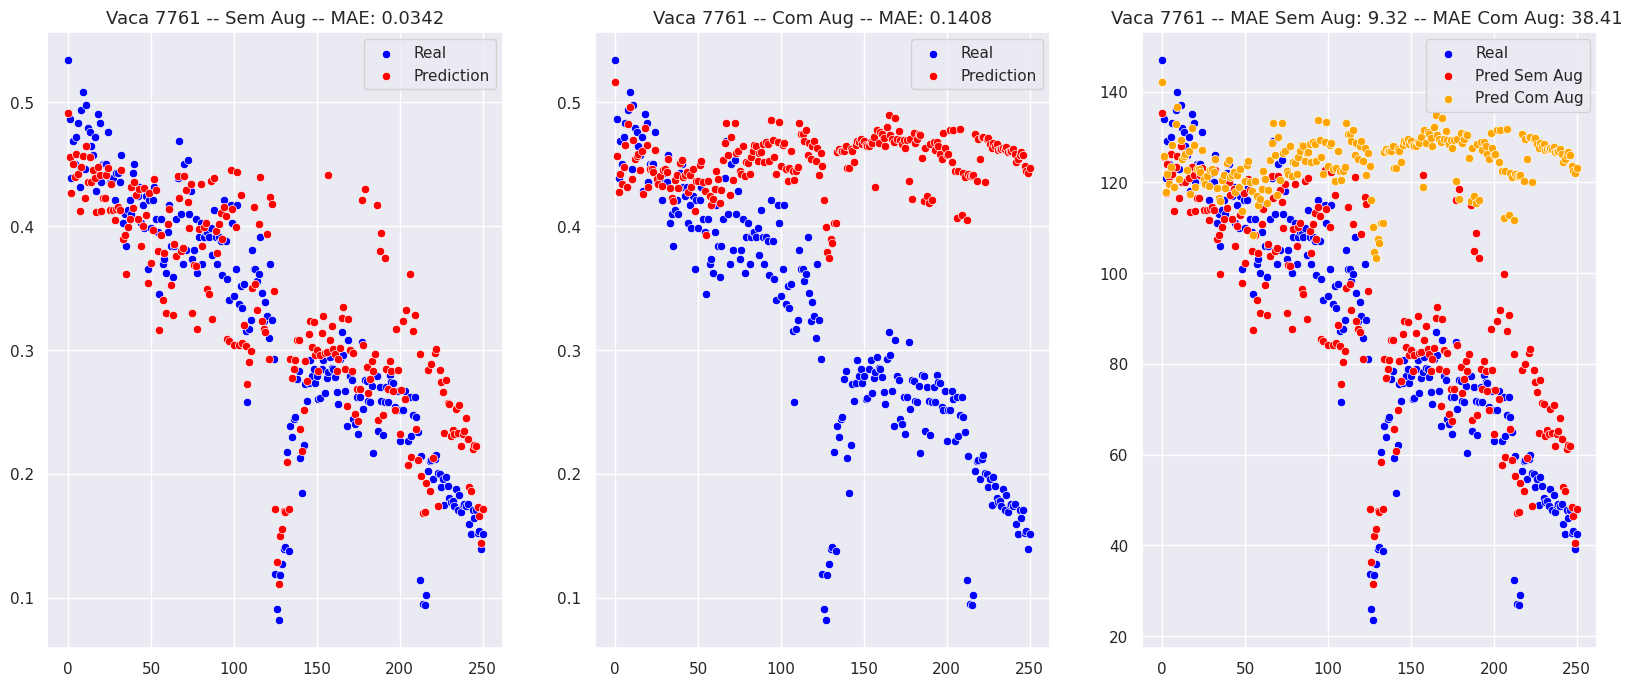

In [ ]:
for i, vaca in enumerate(dv_teste):
    vals = dv_teste[vaca]
    x_test = np.delete(vals, 2, axis=1)
    y_test = vals[:, 2].reshape(-1, 1)
    
    x_teste = x_mmc.transform(x_test)
    y_teste = y_mmc.transform(y_test)
    pred_normal = modelo_normal.predict(x_teste, verbose=0)
    
    x_aug_teste = x_aug_mmc.transform(x_test)
    y_aug_teste = y_aug_mmc.transform(y_test)
    pred_aug = modelo_aug.predict(x_aug_teste, verbose=0)
    
    fig, axes = plt.subplots(1, 3, figsize=(20, 8))
    sns.scatterplot(y_teste.reshape(-1), color='blue', label='Real', ax=axes[0])
    sns.scatterplot(pred_normal.reshape(-1), color='red', label='Prediction', ax=axes[0])
    axes[0].set_title(f'Vaca {vaca} -- Sem Aug -- MAE: {mean_absolute_error(y_teste, pred_normal):.4f}', fontsize=13)

    sns.scatterplot(y_aug_teste.reshape(-1), color='blue', label='Real', ax=axes[1])
    sns.scatterplot(pred_aug.reshape(-1), color='red', label='Prediction', ax=axes[1])
    axes[1].set_title(f'Vaca {vaca} -- Com Aug -- MAE: {mean_absolute_error(y_aug_teste, pred_aug):.4f}', fontsize=13)

    yn = y_mmc.inverse_transform(pred_normal)
    yan = y_aug_mmc.inverse_transform(pred_aug)
    sns.scatterplot(y_test.reshape(-1), color='blue', label='Real', ax=axes[2])
    sns.scatterplot(yn.reshape(-1), color='red', label='Pred Sem Aug', ax=axes[2])
    sns.scatterplot(yan.reshape(-1), color='orange', label='Pred Com Aug', ax=axes[2])
    axes[2].set_title(f'Vaca {vaca} -- MAE Sem Aug: {mean_absolute_error(y_test, yn):.2f} -- MAE Com Aug: {mean_absolute_error(y_test, yan):.2f} ', fontsize=13)
    plt.plot()
    
    # if i == 1:
    #     break
plt.show()